# 2. Run Portfolio Optimization
## MMAI823 - AI in Finance
## Team Humphrey - December 7, 2019

In [1]:
# Main ref: https://people.duke.edu/~ccc14/sta-663/BlackBoxOptimization.html
import numpy as np
import pandas as pd
import scipy
from scipy import optimize

import matplotlib.pyplot as plt
import seaborn as sns

## Parameters

In [2]:
# CAPM parameters
Rf = 0.018
ERm = 0.078
DaysPerYear = 252

## Portfolio Optimization Function: generate_weights
Assumptions:
1. Addition of all weights must equal 1
2. All weights must be >= 0 (no shorting)

In [3]:
# Determine optimal portfolio weights given Covariance V, Expected Returns ER, on range PER_range
def generate_weights(V, ER, PER_range):

    number_tickers = len(ER)

    def portfolio_std_dev(x):
        W = x  # Weights

        # Formula = W x V x WT   (WT = W transpose)
        WT = np.transpose(W)
        WV = np.matmul(W, V)
        var = np.matmul(WV, WT)

        return(np.sqrt(var))

    def portfolio_expected_return(x):
        W = x  # Weights

        # Formula = W . E(r)
        r = np.dot(W, ER)

        return(r)

    # Constraint 1: all items must sum up to 1.0 (100%)
    def const_fun1(x):
        return(np.sum(x) - 1)

    # Constraint 2: expected return must be E
    def const_fun2(x):
        return(portfolio_expected_return(x) - PER)

    # Define bounds for all items from 0 to 1 
    bounds = tuple((0, 1) for i in range(number_tickers))

    # Define constraints
    constraints = ({'type': 'eq', 'fun': const_fun1}, 
                   {'type': 'eq', 'fun': const_fun2})

    results = []
    for i in PER_range:
        # Initial weights and params
        x0 = [0 for i in range(number_tickers)]
        PER = i

        opt = optimize.minimize(portfolio_std_dev, x0, bounds=bounds, constraints=constraints)
        if opt.success:
            port_stdev = portfolio_std_dev(opt.x)
            
            row = []
            row.extend(opt.x)
            row.extend([i])
            row.extend([port_stdev])
            results.append(row)
    
    # Prettify data frame
    df = pd.DataFrame(results)    
    df = df.rename({number_tickers:'Portfolio Expected Return'}, axis='columns')
    df = df.rename({number_tickers+1:'Portfolio Standard Deviation'}, axis='columns')
    cols = df.columns.tolist()
    cols.remove('Portfolio Expected Return')
    cols.remove('Portfolio Standard Deviation')
    cols.insert(0, 'Portfolio Standard Deviation')
    cols.insert(0, 'Portfolio Expected Return')        
    
    return(df[cols])


## Step 1. Grab all the data

In [4]:
df_tickers = pd.read_pickle('df_tickers.pickle')
df_ticker_data = pd.read_pickle('df_ticker_data.pickle')
df_ticker_info = pd.read_pickle('df_ticker_info.pickle')

df_ticker_beta = df_ticker_info[['Ticker', 'Beta']]

In [5]:
# Minor processing
df_ticker_info["MarketCap"] = pd.to_numeric(df_ticker_info["MarketCap"])

In [6]:
df_tickers_combined = pd.merge(left=df_tickers, right=df_ticker_info, how='inner', on='Ticker')

In [7]:
# Create SP500 pick list - i.e. stocks that are "clean", have Beta's, data history, etc.

# 1. Have Betas
df_tickers_combined = df_tickers_combined[df_tickers_combined['Beta'].isnull() == False]

c = df_ticker_data['Close'].columns.tolist()
df_tickers_combined = df_tickers_combined[df_tickers_combined.Ticker.isin(c)]
# 2. included inside df_ticker_data
#df_ticker_data_ticker_list = df_ticker_data['Close'].columns.tolist()
#df_tickers_clean_list_final = list(set(df_ticker_data_ticker_list) - set(df_tickers_clean_list))

In [8]:
df_tickers_combined = df_tickers_combined[df_tickers_combined['Ticker'] != 'GOOGL']  # remove GOOGL, as duplicate of GOOG

In [9]:
df_tickers_combined

,Ticker,Security,SEC filings,GICS Sector,GICS Sub Industry,Headquarters Location,Date first added,CIK,Founded,ShortName,LongName,Beta,MarketCap
0,MMM,3M Company,reports,Industrials,Industrial Conglomerates,"St. Paul, Minnesota",,0000066740,1902,3M Company,3M Company,1.09612,9.860400e+10
1,ABT,Abbott Laboratories,reports,Health Care,Health Care Equipment,"North Chicago, Illinois",1964-03-31,0000001800,1888,Abbott Laboratories,Abbott Laboratories,1.11214,1.511680e+11
2,ABBV,AbbVie Inc.,reports,Health Care,Pharmaceuticals,"North Chicago, Illinois",2012-12-31,0001551152,2013 (1888),AbbVie Inc.,AbbVie Inc.,0.952782,1.286278e+11
3,ABMD,ABIOMED Inc,reports,Health Care,Health Care Equipment,"Danvers, Massachusetts",2018-05-31,0000815094,1981,"ABIOMED, Inc.","Abiomed, Inc.",0.32462,8.544248e+09
4,ACN,Accenture plc,reports,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,0001467373,1989,Accenture plc,Accenture plc,1.03626,1.288143e+11
5,ATVI,Activision Blizzard,reports,Communication Services,Interactive Home Entertainment,"Santa Monica, California",2015-08-31,0000718877,2008,"Activision Blizzard, Inc","Activision Blizzard, Inc.",0.822934,4.241563e+10
6,ADBE,Adobe Systems Inc,reports,Information Technology,Application Software,"San Jose, California",1997-05-05,0000796343,1982,Adobe Inc.,Adobe Inc.,1.10118,1.482395e+11
7,AMD,Advanced Micro Devices Inc,reports,Information Technology,Semiconductors,"Sunnyvale, California",2017-03-20,0000002488,1969,"Advanced Micro Devices, Inc.","Advanced Micro Devices, Inc.",3.07926,4.625098e+10
8,AAP,Advance Auto Parts,reports,Consumer Discretionary,Automotive Retail,"Raleigh, North Carolina",2015-07-09,0001158449,1932,Advance Auto Parts Inc Advance,"Advance Auto Parts, Inc.",0.832209,1.070889e+10
9,AES,AES Corp,reports,Utilities,Independent Power Producers & Energy Traders,"Arlington, Virginia",1998-10-02,0000874761,1981,The AES Corporation,The AES Corporation,1.07504,1.242808e+10


## Step 2. Select Stocks for Portfolio
Selection Criteria:
1. select 10 largest stocks by market capitalization
2. for the remaining stockes, add 3 stocks at random from each of the 11 GICS Sectors

In [10]:
# Create empty portfolio
df_portfolio = pd.DataFrame({'Ticker':[]})

In [11]:
# 1. select 10 largest stocks by market capitalization
df_top10 = df_tickers_combined.nlargest(10, 'MarketCap')[['Ticker']]
a = df_tickers_combined.Ticker.tolist()
b = df_top10.Ticker.tolist()
c = list(set(a) - set(b))
df_tickers_no_top10 = df_tickers_combined[df_tickers_combined.Ticker.isin(c)]
df_portfolio = df_portfolio.append(df_top10)

# 2. for the remaining stockes, add 3 stocks at random from each of the 11 GICS Sectors
for sector in df_tickers_no_top10.groupby('GICS Sector').count().index.tolist():
    df_portfolio = df_portfolio.append(df_tickers_no_top10[df_tickers_no_top10['GICS Sector']==sector].sample(3, random_state = 3)[['Ticker']])
        
df_portfolio = df_portfolio.reset_index().drop(['index'], axis=1)

In [12]:
print(df_portfolio.Ticker.to_list())

['AAPL', 'MSFT', 'GOOG', 'AMZN', 'FB', 'JPM', 'V', 'JNJ', 'WMT', 'PG', 'TMUS', 'CTL', 'T', 'CPRI', 'TJX', 'RCL', 'SJM', 'CLX', 'KR', 'NOV', 'MPC', 'HP', 'UNM', 'BBT', 'FRC', 'RMD', 'CI', 'WCG', 'CMI', 'WAB', 'NSC', 'WDC', 'ADP', 'IT', 'NEM', 'MOS', 'IP', 'PLD', 'KIM', 'CBRE', 'NEE', 'FE', 'EIX']


## Step 3. Generate Covariance Matrix

In [13]:
#1. Select price data for portfolio
df_portfolio_hist = df_ticker_data['Close'][df_portfolio['Ticker']]

# Add risk free component
df_portfolio_hist['_RF_'] = Rf / DaysPerYear

In [14]:
#2. Calculate returns
df_portfolio_returns = df_portfolio_hist.pct_change().dropna()

In [15]:
#3. Calculate covariance matrix
df_cov = pd.DataFrame(np.cov(df_portfolio_returns.to_numpy().transpose(), ddof=0), 
                      columns = df_portfolio_returns.columns, 
                      index = df_portfolio_returns.columns) * DaysPerYear # Scale daily to annual


## Step 4. Generate Expected Returns by Stock

In [16]:
# Calculate expected returns by stock ticker
df_portfolio_return = df_portfolio.join(df_ticker_beta.set_index('Ticker'), on='Ticker')

df_portfolio_return['Expected Return'] = Rf + df_portfolio_return['Beta'] * (ERm - Rf)

# Add risk free coponent
df_portfolio_return.loc[df_portfolio_return['Ticker'].count()] = ['_RF_', 1.0, Rf] 

In [17]:
df_portfolio_return

,Ticker,Beta,Expected Return
0,AAPL,1.2285,0.0917099
1,MSFT,1.23103,0.0918617
2,GOOG,1.02276,0.0793659
3,AMZN,1.51686,0.109012
4,FB,1.06239,0.0817436
5,JPM,1.21838,0.0911029
6,V,0.934232,0.0740539
7,JNJ,0.700674,0.0600404
8,WMT,0.376897,0.0406138
9,PG,0.381112,0.0408667


## Step 5. Generate Optimal Portfolio Weights
Assumptions:
1. Cannot short a stock (any given weight has to be greater than or equal to 0
2. Cannot borrow at Risk Free rate

In [18]:
# With Risk Free portfolio

# Covariance 
V = df_cov.to_numpy().tolist()

# Expected returns
ER = df_portfolio_return['Expected Return'].to_numpy().tolist()

df_portfolio_weights = generate_weights(V, ER, np.arange(0.02, 0.20, 0.001))

In [19]:
df_portfolio_weights.columns = df_portfolio_weights.columns[:2].tolist() + df_portfolio.Ticker.to_list()+['RF']
df_portfolio_weights

,Portfolio Expected Return,Portfolio Standard Deviation,AAPL,MSFT,GOOG,AMZN,FB,JPM,V,JNJ,...,NEM,MOS,IP,PLD,KIM,CBRE,NEE,FE,EIX,RF
0,0.020,0.003889,2.252884e-04,1.640528e-18,7.344809e-18,2.701372e-03,1.497402e-18,5.379286e-18,3.497809e-18,1.367704e-03,...,6.997985e-18,6.305078e-04,3.015526e-03,3.388265e-03,4.323409e-18,0.002039,1.849103e-17,6.640427e-18,1.665746e-17,9.759165e-01
1,0.021,0.005833,2.764011e-04,9.113732e-18,8.755151e-18,3.925631e-03,1.374324e-17,6.489362e-18,1.021712e-17,2.181871e-03,...,4.839346e-18,9.544154e-04,4.878023e-03,4.978301e-03,5.615896e-18,0.003276,2.738446e-18,2.311177e-18,2.567297e-18,9.639109e-01
2,0.022,0.007777,2.325134e-04,1.685513e-18,4.628149e-18,5.165065e-03,1.553161e-18,1.923117e-18,1.192539e-17,3.071632e-03,...,5.306113e-18,1.249614e-03,6.497782e-03,6.888671e-03,2.454601e-18,0.004326,7.923508e-18,6.280039e-18,5.722739e-18,9.516882e-01
3,0.023,0.009721,2.917292e-04,1.497485e-19,1.023236e-17,6.517765e-03,1.515302e-17,1.377482e-17,1.754513e-17,3.862726e-03,...,2.890113e-18,1.506353e-03,8.157128e-03,8.571847e-03,1.325786e-17,0.005464,1.875938e-17,1.817052e-17,3.164750e-18,9.396507e-01
4,0.024,0.011665,3.791286e-04,5.774824e-18,1.988304e-17,7.921279e-03,8.477871e-18,1.445497e-18,3.341763e-18,4.596890e-03,...,2.630559e-18,1.832216e-03,9.784853e-03,1.019533e-02,1.861981e-18,0.006481,8.807386e-18,6.113551e-18,7.964996e-18,9.275616e-01
5,0.025,0.013609,5.730733e-04,0.000000e+00,0.000000e+00,8.976433e-03,0.000000e+00,0.000000e+00,0.000000e+00,5.098238e-03,...,1.401794e-18,2.080851e-03,1.143960e-02,1.159437e-02,3.980467e-19,0.007847,0.000000e+00,2.668979e-17,2.405964e-17,9.157350e-01
6,0.026,0.015553,5.286849e-04,0.000000e+00,3.983668e-18,1.048814e-02,1.528582e-17,1.596794e-18,9.712637e-18,5.955750e-03,...,6.297556e-18,2.484866e-03,1.306109e-02,1.351583e-02,1.323637e-17,0.008584,2.167970e-18,1.400254e-17,7.449411e-18,9.035561e-01
7,0.027,0.017497,6.857963e-04,2.201460e-17,4.681271e-18,1.183819e-02,2.395388e-17,2.407173e-17,3.667354e-18,6.915972e-03,...,5.332321e-18,2.926995e-03,1.479805e-02,1.528126e-02,7.747457e-18,0.009467,2.845688e-17,2.159985e-17,2.417577e-17,8.913275e-01
8,0.028,0.019441,5.333580e-04,0.000000e+00,0.000000e+00,1.309041e-02,3.783142e-17,0.000000e+00,4.359718e-17,7.450488e-03,...,0.000000e+00,3.322663e-03,1.625788e-02,1.670619e-02,2.305151e-17,0.010466,0.000000e+00,1.910802e-17,3.915149e-17,8.794346e-01
9,0.029,0.021385,7.399562e-04,7.278415e-18,6.355136e-18,1.436225e-02,6.896009e-18,1.179889e-17,1.017913e-17,8.275707e-03,...,1.767855e-18,3.444689e-03,1.795528e-02,1.858037e-02,8.069084e-18,0.011733,0.000000e+00,1.037087e-17,9.665525e-18,8.671821e-01


In [20]:
# Without Risk Free portfolio


# Covariance 
V = df_cov.iloc[:-1,:-1].to_numpy().tolist()

# Expected returns
ER = df_portfolio_return['Expected Return'].to_numpy().tolist()[:-1]

df_portfolio_weights_rf = generate_weights(V, ER, np.arange(0.02, 0.20, 0.001))

## Step 6. Plot Graphs

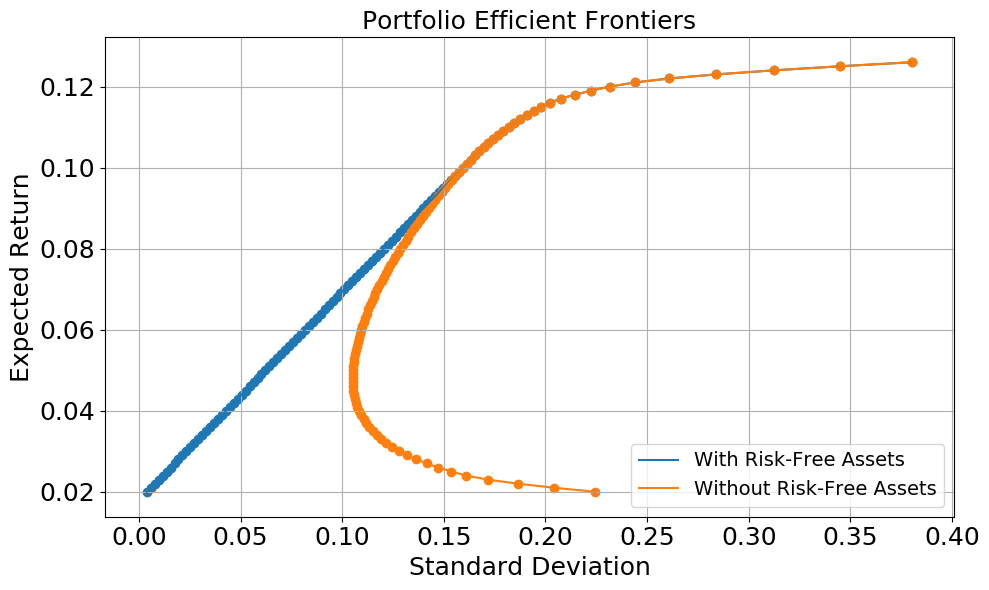

In [21]:
import matplotlib.pyplot as plt

x = df_portfolio_weights['Portfolio Standard Deviation'].tolist()
y = df_portfolio_weights['Portfolio Expected Return'].tolist()
x2 = df_portfolio_weights_rf['Portfolio Standard Deviation'].tolist()
y2 = df_portfolio_weights_rf['Portfolio Expected Return'].tolist()

plt.style.use('default')
figure = plt.figure(figsize=(10, 6))
ax = plt.subplot(1, 1, 1)

def plot_scatter(x, y, name, ax):
    ax.plot(x, y, label="{}".format(name))
    ax.scatter(x,y)
    ax.set_xlabel('Standard Deviation', fontsize=18)
    ax.set_ylabel('Expected Return', fontsize=18)
    ax.tick_params(axis='both', which='major', labelsize=18)
    ax.grid(True);
    ax.set_title('Portfolio Efficient Frontiers', fontsize=18)     

plot_scatter(x,y,'With Risk-Free Assets',ax)
plot_scatter(x2,y2,'Without Risk-Free Assets',ax)    


plt.legend(loc='lower right', fontsize=14)
plt.tight_layout()